## PyCPT_sv1.2 --8 June 2019
## Produce seasonal (un)calibrated forecasts and assess associated skill 


#### Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu) and Andrew W. Robertson (awr@iri.columbia.edu)

#### Acknowledgements: 
Simon J. Mason (IRI) for CPT core development.
Rémi Cousin (IRI) for key Ingrid code development and support.
Xandre Chourio (IRI) for Windows and code support, and testing.
James Doss-Gollin (Columbia Water Center) developed the original download Python functions.
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson).

#### Version log
* First Notebook seasonal version by AGM -- May 7th 2019
* Several PyCPT sub-seasonal versions (through v1.2) --see logs in that version 2018-present
* First iPython sub-seasonal version (Jupyter Notebook) by AWR -- 24 Jun 2018
* First similar version (BASH for CFSv2) by Muñoz and Chourio for the OLE2 -- 12 Dec 2010 

#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7) or CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.

#### Notes:
1. Old data in the input folder is deleted at the beginning of the process!

### Namelist section

In [7]:
########Work name (name of the work folder; e.g., one word followed by "_seasonal":)
work='IAS_seasonal'

########Model (choose one, a subset or all models: 
#CMC1-CanCM3*, CMC2-CanCM4*, COLA-RSMAS-CCSM3, COLA-RSMAS-CCSM4*, 
#GFDL-CM2p1, GFDL-CM2p5-FLOR-A06*, GFDL-CM2p5-FLOR-B01*, NASA-GEOSS2S*, NCAR-CESM1, NCEP-CFSv2*)
#The ones with "*" are producing operational forecasts, the others are frozen. 
models=['CMC1-CanCM3', 'CMC2-CanCM4', 'COLA-RSMAS-CCSM4', 'GFDL-CM2p5-FLOR-A06', 
       'GFDL-CM2p5-FLOR-B01', 'NASA-GEOSS2S', 'NCEP-CFSv2']
#models=['CMC1-CanCM3'] #, 'CMC2-CanCM4', 'COLA-RSMAS-CCSM4', 'GFDL-CM2p5-FLOR-A06']

########Obs (choose between CPC-CMAP-URD, CHIRPS, TRMM, CPC)
obs='CPC-CMAP-URD'

########MOS method (choose between None, PCR, CCA and ELR)
MOS='CCA'

########Target seasons and related parameters
##If more targets, increase the arrays accordingly
mons=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
tgti='1.5'   #S: start for the DL
tgtf='3.5'   #S: end for the DL
#for now, just write the target period (for DL)
tgts=['Feb-Apr','Mar-May','Apr-Jun','May-Jul','Jun-Aug','Jul-Sep','Aug-Oct','Sep-Nov','Oct-Dec','Nov-Jan','Dec-Feb','Jan-Mar'] 
L=['1'] #lead for file name (it depends on how the DL has been configured in the country)
ntrain= 28 # length of training period (1982-2009)

########Forecast date  
monf='Jun' 	# Initialization month 
fyr=2019 	# Forecast year

########Switches:
force_download = False   #force download of data files, even if they already exist locally

# Rainfall frequency switch ---DO NOT MODIFY this block!
rainfall_frequency = False  #False uses total rainfall for forecast period, True uses frequency of rainy days
wetday_threshold = 3 #WET day threshold (mm) --only used if rainfall_frequency is True!
threshold_pctle = False    #False for threshold in mm; Note that if True then if counts DRY days!!!

########Spatial domain for predictor
nla1=40 	# Northernmost latitude
sla1=-60 	# Southernmost latitude
wlo1=-130 	# Westernmost longitude
elo1=-20 	# Easternmost longitude
# Spatial domain for predictand
nla2=35 	# Northernmost latitude
sla2=-55 	# Southernmost latitude
wlo2=-120 	# Westernmost longitude
elo2=-30 	# Easternmost longitude

In [8]:
########Some folder and file options:
# Working directory --it should exist!!!
workdir = '/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/'
# PATH to CPT root directory
cptdir='/Users/agmunoz/Documents/Angel/CPT/CPT/16.0.1/'

########Naming of output files
if rainfall_frequency:
    fprefix = 'RFREQ'
else:
    fprefix = 'PRCP'
    
########Observation dataset URLs
if obs == 'CPC-CMAP-URD':
    obs_source = 'SOURCES/.Models/.NMME/.CPC-CMAP-URD/prate'
    hdate_last = 2010
elif obs == 'TRMM':
    obs_source = 'SOURCES/.NASA/.GES-DAAC/.TRMM_L3/.TRMM_3B42/.v7/.daily/.precipitation/X/0./1.5/360./GRID/Y/-50/1.5/50/GRID'
    hdate_last = 2014
elif obs == 'CPC':
    obs_source = 'SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/X/0./1.5/360./GRID/Y/-90/1.5/90/GRID'
    hdate_last = 2018
elif obs == 'CHIRPS':
    obs_source = 'SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/X/0./.5/360./GRID/Y/-90/.5/90/GRID'
    hdate_last = 2018
else:
    print ("Obs option is invalid")
    
########MOS-dependent parameters
if MOS=='None':
    mpref='noMOS'
elif MOS=='CCA':
    mpref='CCA'
elif MOS=='PCR':
    mpref='PCR'
elif MOS=='ELR':
    mpref='ELRho'
#else:
#    print ("MOS option is invalid")

print("PyCPT folder is:")
%cd $workdir
!mkdir -p $work

PyCPT folder is:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT


### End of namelist section  (do not modify anything below this line)

#### Load Libraries

In [9]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from pycpt_functions_seasonal import *
from scipy.stats import t
if MOS=='ELR':
    from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
print("Python ibraries loaded")
print("Now in the work folder:")
%cd $work
workdir = os.getcwd()

Python ibraries loaded
Now in the work folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal


In [4]:
if rainfall_frequency:
    print('Predictand is Rainfall Frequency; wet day threshold = '+str(wetday_threshold)+' mm')
else:
    print('Predictand is Rainfall Total (mm)')
    
print("Creating working folders, if not already there...")
print("Work directory is:")
%cd $workdir
!mkdir -p input
!mkdir -p output
!mkdir -p scripts
!rm -Rf scripts/*

# Set up CPT environment
os.environ["CPT_BIN_DIR"] = cptdir
print("CPT environment loaded...")
#print("CPT version is "+str(wetday_threshold))

Predictand is Rainfall Total (mm)
Creating working folders, if not already there...
Work directory is:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal
CPT environment loaded...


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

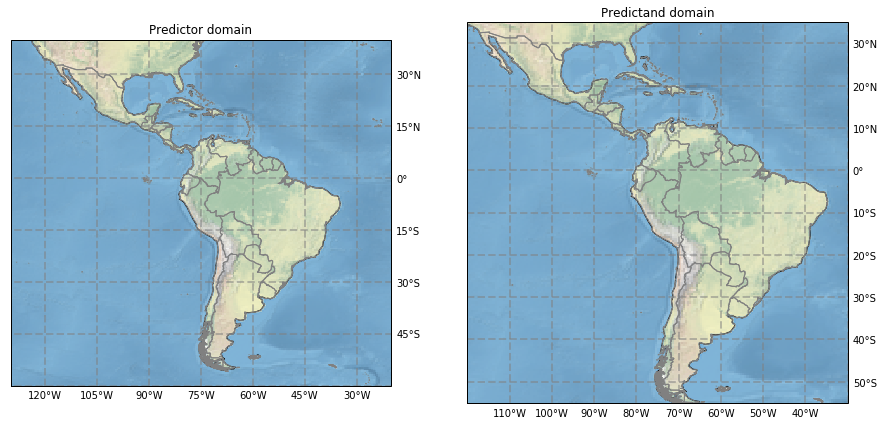

In [10]:
#Plot domains
pltdomain(wlo1,elo1,nla1,sla1,wlo2,elo2,nla2,sla2)

# Download data if necessary, and run CPT

In [11]:
for model in models:
    print('')
    print('')
    print('----Starting process for '+model+'----')
    for mon in mons:
        tar=tgts[mons.index(mon)]
        print("New folder:")
        %cd $workdir/input

        print('Preparing CPT files for '+model+' and initialization '+mon+'...')
        PrepFiles(rainfall_frequency, threshold_pctle, wlo1, wlo2,elo1, elo2, sla1, sla2, nla1, nla2, tgti, tgtf, mon, monf, fyr, os, wetday_threshold, tar, model, obs_source, hdate_last, force_download)
 
        print("New folder:")
        %cd $workdir/scripts

        CPTscript(model,mon,monf, fyr, nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,rainfall_frequency,MOS)

        print('Executing CPT for '+model+' and initialization '+mon+'...')
        os.system(cptdir+'CPT.x < params > CPT_stout_train_'+model+'_'+tar+'_'+mon+'.txt')
        print('----------------------------------------------')
        print('Calculations for '+mon+' initialization completed!')
        print('See output folder, and check scripts/CPT_stout_train_'+model+'_'+tar+'_'+mon+'.txt for errors')
        print('----------------------------------------------')
        print('----------------------------------------------')





----Starting process for CMC1-CanCM3----
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/input
Preparing CPT files for CMC1-CanCM3 and initialization Jan...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/scripts
Executing CPT for CMC1-CanCM3 and initialization Jan...
----------------------------------------------
Calculations for Jan initialization completed!
See output folder, and check scripts/CPT_stout_train_CMC1-CanCM3_Feb-Apr_Jan.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/input
Preparing CPT files for CMC1-CanCM3 and initializ

Executing CPT for CMC1-CanCM3 and initialization Nov...
----------------------------------------------
Calculations for Nov initialization completed!
See output folder, and check scripts/CPT_stout_train_CMC1-CanCM3_Dec-Feb_Nov.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/input
Preparing CPT files for CMC1-CanCM3 and initialization Dec...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/scripts
Executing CPT for CMC1-CanCM3 and initialization Dec...
----------------------------------------------
Calculations for Dec initialization completed!
See output folder, and check scripts/

----------------------------------------------
Calculations for Sep initialization completed!
See output folder, and check scripts/CPT_stout_train_CMC2-CanCM4_Oct-Dec_Sep.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/input
Preparing CPT files for CMC2-CanCM4 and initialization Oct...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/scripts
Executing CPT for CMC2-CanCM4 and initialization Oct...
----------------------------------------------
Calculations for Oct initialization completed!
See output folder, and check scripts/CPT_stout_train_CMC2-CanCM4_Nov-Jan_Oct.txt for errors
-

Executing CPT for COLA-RSMAS-CCSM4 and initialization Jul...
----------------------------------------------
Calculations for Jul initialization completed!
See output folder, and check scripts/CPT_stout_train_COLA-RSMAS-CCSM4_Aug-Oct_Jul.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/input
Preparing CPT files for COLA-RSMAS-CCSM4 and initialization Aug...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/scripts
Executing CPT for COLA-RSMAS-CCSM4 and initialization Aug...
----------------------------------------------
Calculations for Aug initialization completed!
See output folder

Executing CPT for GFDL-CM2p5-FLOR-A06 and initialization May...
----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_GFDL-CM2p5-FLOR-A06_Jun-Aug_May.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/input
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization Jun...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/scripts
Executing CPT for GFDL-CM2p5-FLOR-A06 and initialization Jun...
----------------------------------------------
Calculations for Jun initialization completed!
See o

Executing CPT for GFDL-CM2p5-FLOR-B01 and initialization Mar...
----------------------------------------------
Calculations for Mar initialization completed!
See output folder, and check scripts/CPT_stout_train_GFDL-CM2p5-FLOR-B01_Apr-Jun_Mar.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/input
Preparing CPT files for GFDL-CM2p5-FLOR-B01 and initialization Apr...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/scripts
Executing CPT for GFDL-CM2p5-FLOR-B01 and initialization Apr...
----------------------------------------------
Calculations for Apr initialization completed!
See o

Executing CPT for NASA-GEOSS2S and initialization Jan...
----------------------------------------------
Calculations for Jan initialization completed!
See output folder, and check scripts/CPT_stout_train_NASA-GEOSS2S_Feb-Apr_Jan.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/input
Preparing CPT files for NASA-GEOSS2S and initialization Feb...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/scripts
Executing CPT for NASA-GEOSS2S and initialization Feb...
----------------------------------------------
Calculations for Feb initialization completed!
See output folder, and check scri

----------------------------------------------
Calculations for Nov initialization completed!
See output folder, and check scripts/CPT_stout_train_NASA-GEOSS2S_Dec-Feb_Nov.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/input
Preparing CPT files for NASA-GEOSS2S and initialization Dec...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/scripts
Executing CPT for NASA-GEOSS2S and initialization Dec...
----------------------------------------------
Calculations for Dec initialization completed!
See output folder, and check scripts/CPT_stout_train_NASA-GEOSS2S_Jan-Mar_Dec.txt for erro

Executing CPT for NCEP-CFSv2 and initialization Oct...
----------------------------------------------
Calculations for Oct initialization completed!
See output folder, and check scripts/CPT_stout_train_NCEP-CFSv2_Nov-Jan_Oct.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/input
Preparing CPT files for NCEP-CFSv2 and initialization Nov...
Hindcasts file ready to go
----------------------------------------------
Obs:precip file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/scripts
Executing CPT for NCEP-CFSv2 and initialization Nov...
----------------------------------------------
Calculations for Nov initialization completed!
See output folder, and check scripts/CPT_

## Deterministic Skill Analysis

Present folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/output

Spearman


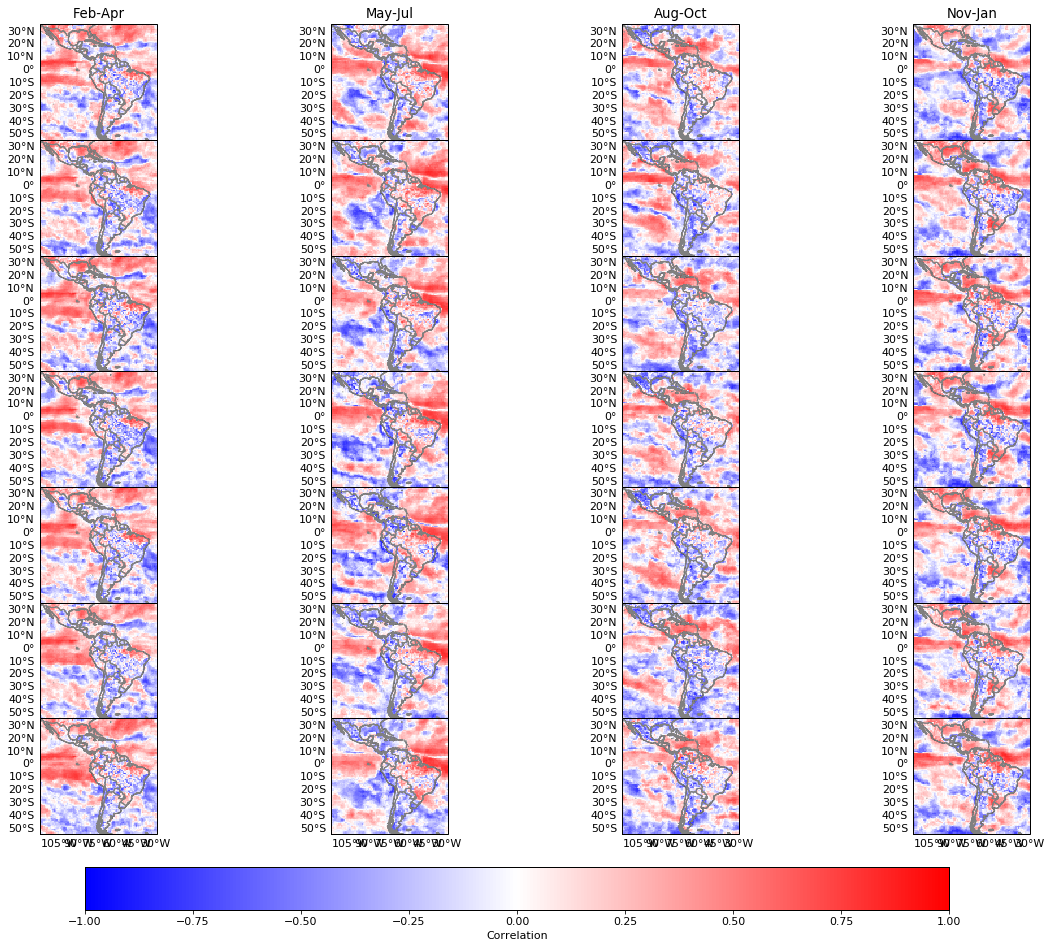



2AFC


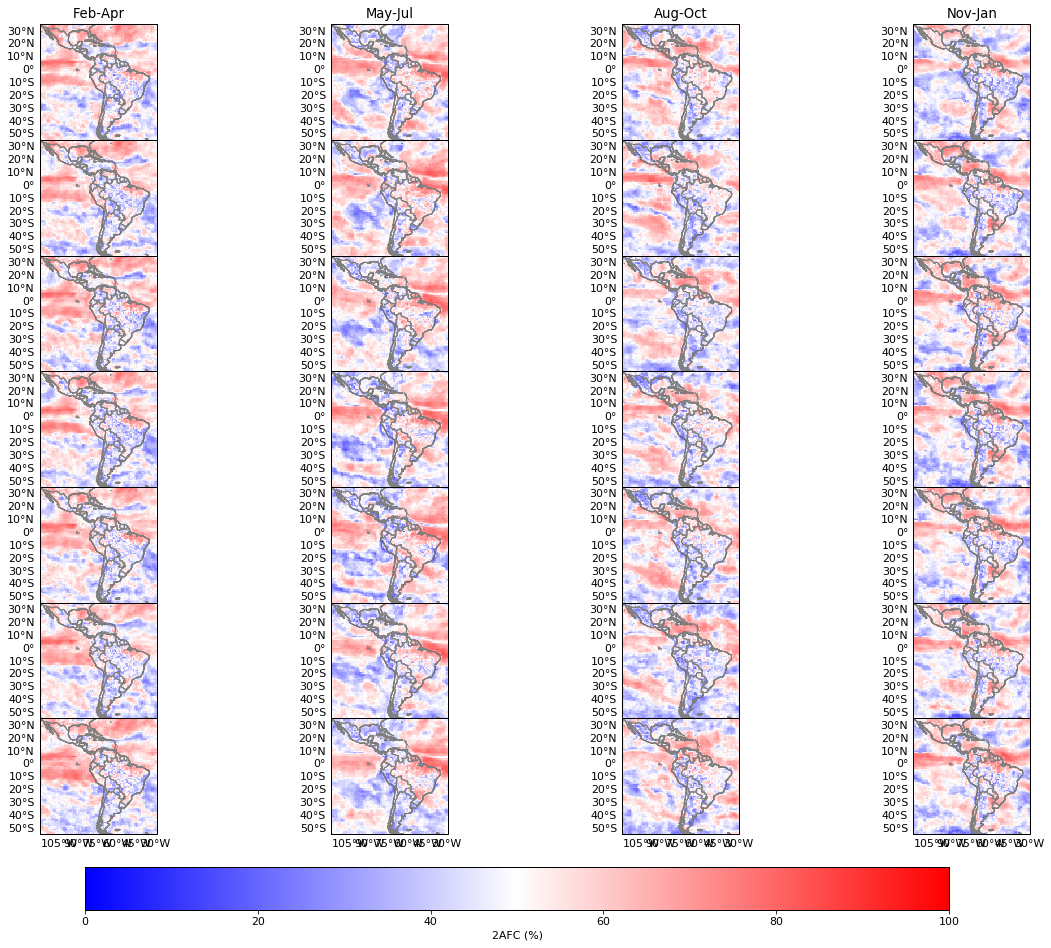



RocAbove


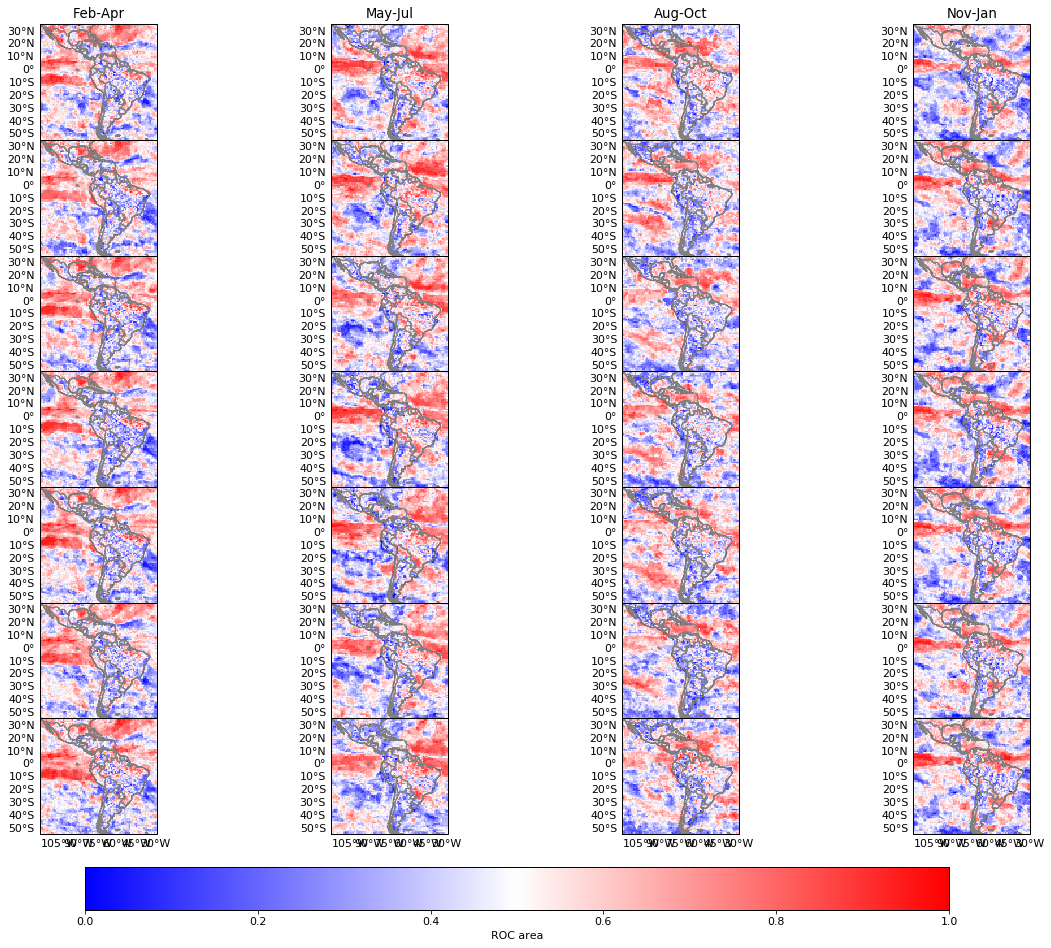



RocBelow


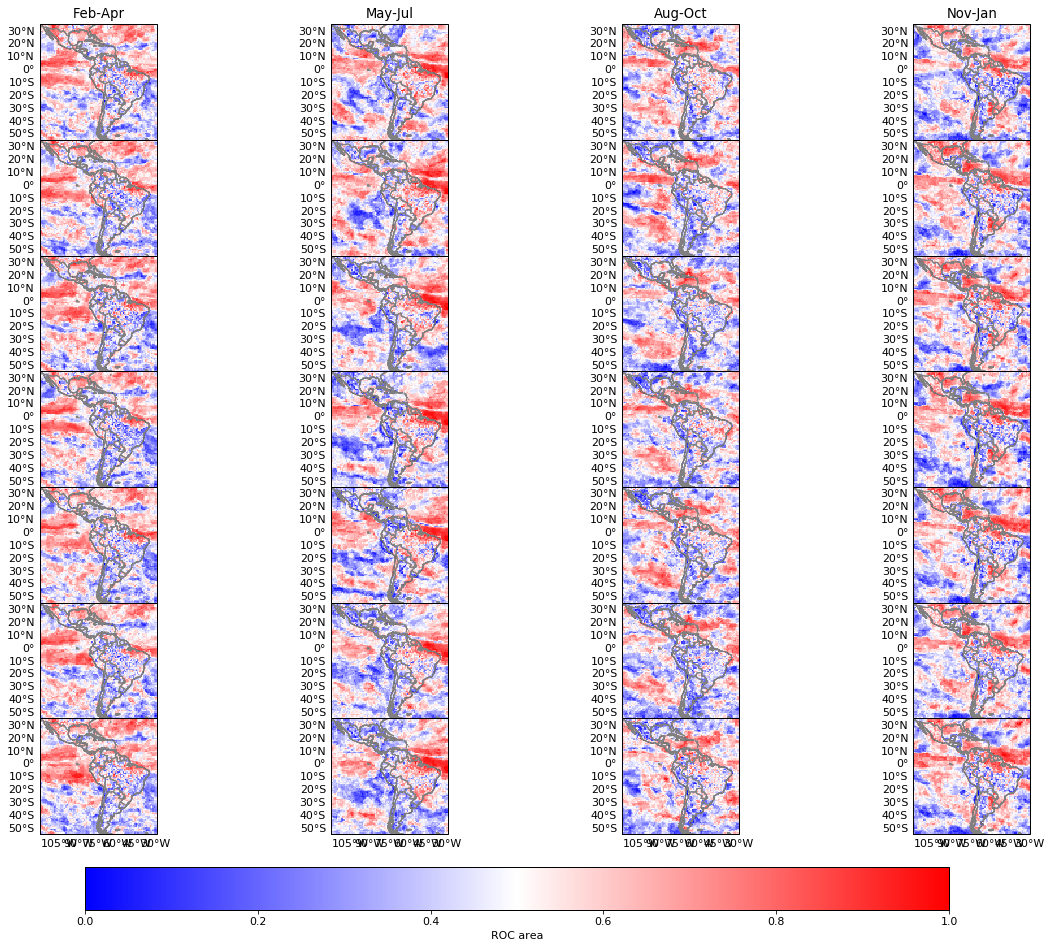

In [12]:
#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow'):
met=('Spearman','2AFC','RocAbove','RocBelow')

print("Present folder:")
%cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 11})
for ime in met:
    pltmap(models,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts, mons)   
    print('')
    print(ime)
    plt.show()
    print('')

## EOF Analysis (only available if MOS=PCR or CCA)

Present folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/IAS_seasonal/output


Mode 1


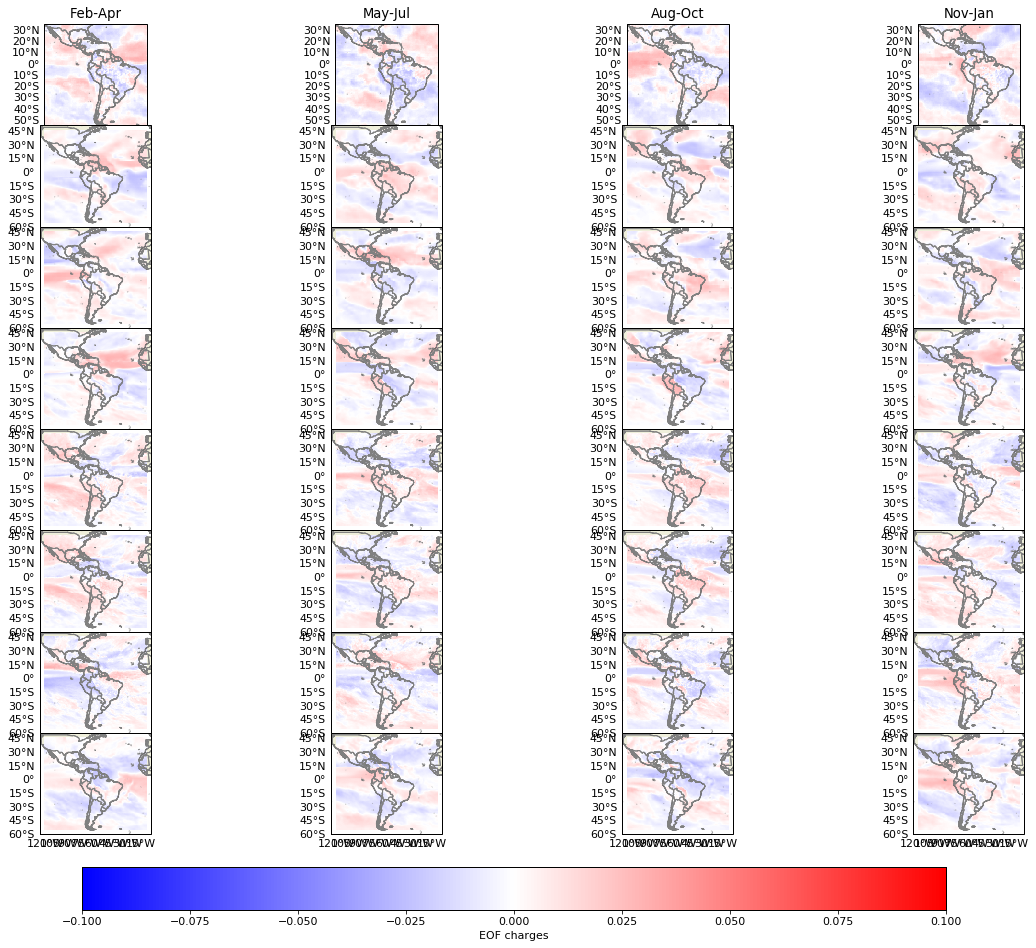

Mode 2


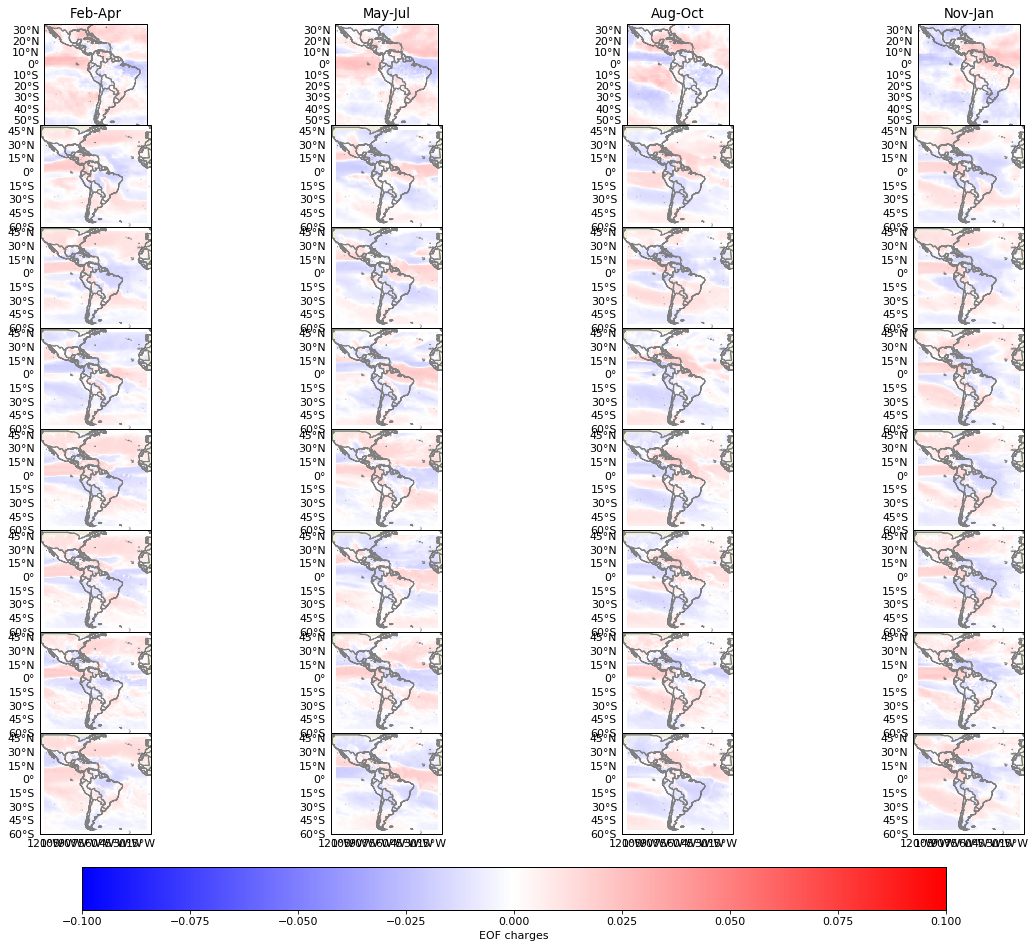

Mode 3


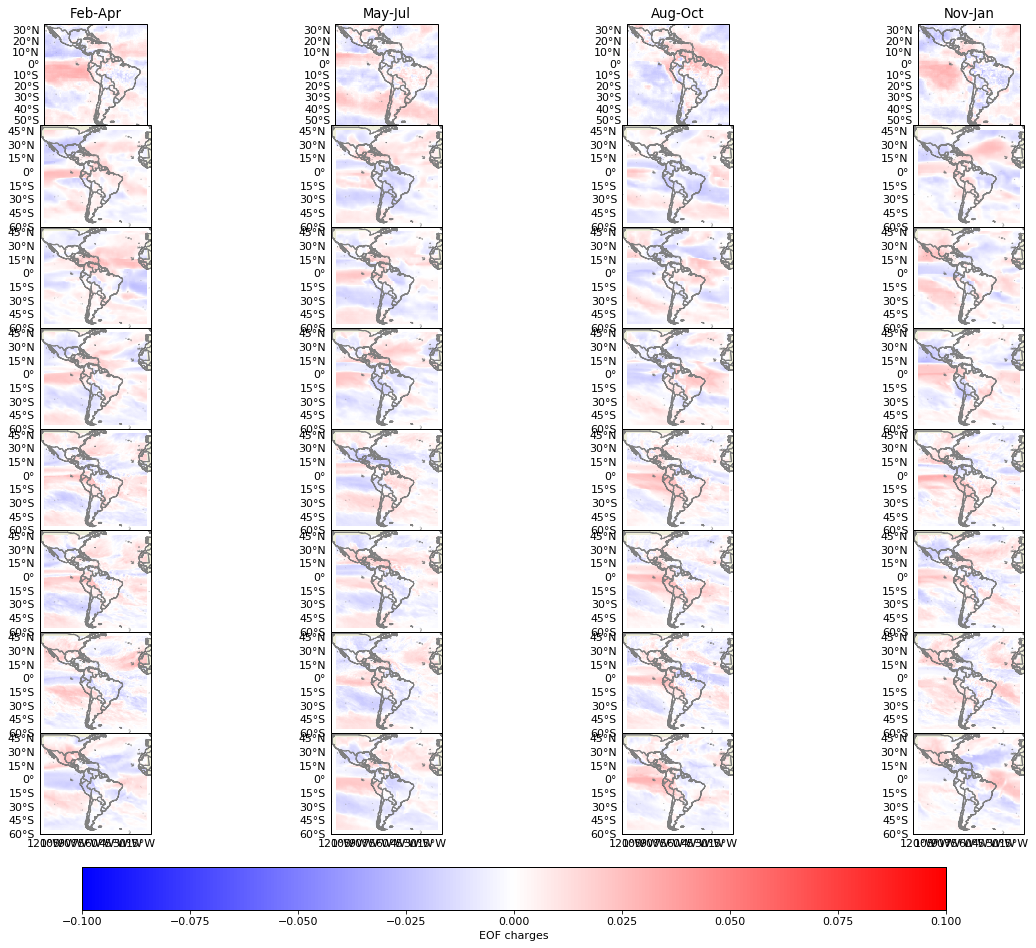

In [13]:
print("Present folder:")
%cd $workdir/output
print('')
print('')

# Skill scores loop
plt.rcParams.update({'font.size': 11})
nmodes=3
for imod in range(nmodes):
    plteofs(models,imod,nmodes,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts, mons)   
    print("Mode "+str(imod+1))
    plt.show()

## Multi-model ensemble

In [5]:
#List of selected models:
models=['CMC1-CanCM3', 'CMC2-CanCM4', 'COLA-RSMAS-CCSM4', 'GFDL-CM2p5-FLOR-A06', 
       'GFDL-CM2p5-FLOR-B01', 'NASA-GEOSS2S', 'NCEP-CFSv2']

In [6]:
ensemblefiles(models,work)

mkdir: ../output/NextGen/: File exists
cp: ../*CMC1-CanCM3*.txt: No such file or directory
cp: ../*CMC2-CanCM4*.txt: No such file or directory
cp: ../*COLA-RSMAS-CCSM4*.txt: No such file or directory
cp: ../*GFDL-CM2p5-FLOR-A06*.txt: No such file or directory
cp: ../*GFDL-CM2p5-FLOR-B01*.txt: No such file or directory
cp: ../*NASA-GEOSS2S*.txt: No such file or directory
cp: ../*NCEP-CFSv2*.txt: No such file or directory
a input
a input/CMC2-CanCM4fcst_precip_Jul-Sep_iniJun2019.tsv
a input/CMC2-CanCM4fcst_precip_Feb-Apr_iniJun2019.tsv
a input/CMC1-CanCM3fcst_precip_Mar-May_iniJun2019.tsv
a input/CMC1-CanCM3fcst_precip_Oct-Dec_iniJun2019.tsv
a input/COLA-RSMAS-CCSM4_precip_Jul-Sep_iniJun.tsv
a input/CMC2-CanCM4fcst_precip_Apr-Jun_iniJun2019.tsv
a input/NASA-GEOSS2S_precip_Sep-Nov_iniAug.tsv
a input/obs_precip_Mar-May.tsv
a input/CMC2-CanCM4fcst_precip_Dec-Feb_iniJun2019.tsv
a input/CMC2-CanCM4_precip_Dec-Feb_iniNov.tsv
a input/NCEP-CFSv2fcst_precip_Aug-Oct_iniJun2019.tsv
a input/GFDL-CM2

a input/CMC1-CanCM3fcst_precip_Jul-Sep_iniJun2019.tsv
a input/CMC1-CanCM3fcst_precip_Feb-Apr_iniJun2019.tsv
a input/CMC1-CanCM3fcst_precip_Apr-Jun_iniJun2019.tsv
a input/NASA-GEOSS2S_precip_Dec-Feb_iniNov.tsv
a input/CMC2-CanCM4_precip_Sep-Nov_iniAug.tsv
a input/NCEP-CFSv2_precip_Jul-Sep_iniJun.tsv
a input/CMC1-CanCM3fcst_precip_Dec-Feb_iniJun2019.tsv
a input/obs_precip_Apr-Jun.tsv
a input/GFDL-CM2p5-FLOR-B01fcst_precip_Aug-Oct_iniJun2019.tsv
a input/NASA-GEOSS2S_precip_Feb-Apr_iniJan.tsv
a input/CMC1-CanCM3fcst_precip_Jun-Aug_iniJun2019.tsv
a input/NASA-GEOSS2S_precip_Jan-Mar_iniDec.tsv
a input/COLA-RSMAS-CCSM4fcst_precip_Aug-Oct_iniJun2019.tsv
a input/GFDL-CM2p5-FLOR-A06_precip_Jul-Sep_iniJun.tsv
a input/CMC2-CanCM4_precip_Jun-Aug_iniMay.tsv
a input/CMC2-CanCM4fcst_precip_May-Jul_iniJun2019.tsv
a input/CMC2-CanCM4_precip_Mar-May_iniFeb.tsv
a input/NASA-GEOSS2Sfcst_precip_Jan-Mar_iniJun2019.tsv
a input/NCEP-CFSv2fcst_precip_Dec-Feb_iniJun2019.tsv
a input/NCEP-CFSv2_precip_Nov-Jan_iniO

a output/NCEP-CFSv2_PRCP_CCA_EOFX_Dec-Feb_Nov.dat
a output/CMC1-CanCM3_PRCP_CCA_EOFX_Aug-Oct_Jul.dat
a output/COLA-RSMAS-CCSM4_PRCP_CCA_Spearman_Jul-Sep_Jun.dat
a output/NASA-GEOSS2S_PRCP_CCA_RocAbove_Sep-Nov_Aug.ctl
a output/CMC1-CanCM3_PRCP_CCA_Spearman_Aug-Oct_Jul.ctl
a output/COLA-RSMAS-CCSM4_PRCP_CCA_Spearman_Apr-Jun_Mar.ctl
a output/NCEP-CFSv2_PRCP_CCA_2AFC_Aug-Oct_Jul.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_RocAbove_Oct-Dec_Sep.dat
a output/CMC2-CanCM4_PRCP_CCA_Spearman_Mar-May_Feb.ctl
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_Spearman_Dec-Feb_Nov.dat
a output/CMC1-CanCM3_PRCP_noMOS_RocAbove_Sep-Nov_Aug.ctl
a output/COLA-RSMAS-CCSM4_PRCP_noMOS_RocBelow_Aug-Oct_Jul.dat
a output/CMC2-CanCM4_PRCP_CCA_Obs_Aug-Oct_Jul.ctl
a output/COLA-RSMAS-CCSM4_PRCP_CCA_RocAbove_Oct-Dec_Sep.ctl
a output/COLA-RSMAS-CCSM4_PRCP_CCA_2AFC_Jan-Mar_Dec.ctl
a output/NASA-GEOSS2S_PRCP_CCA_2AFC_Jan-Mar_Dec.dat
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_EOFY_Apr-Jun_Mar.ctl
a output/NCEP-CFSv2_PRCP_CCA_EOFY_Jun-A

a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_EOFX_Nov-Jan_Oct.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_Pearson_Jun-Aug_May.ctl
a output/CMC1-CanCM3_PRCP_CCA_RocBelow_Jun-Aug_May.ctl
a output/CMC1-CanCM3_PRCP_CCA_EOFY_Mar-May_Feb.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_EOFY_Jun-Aug_May.dat
a output/NCEP-CFSv2_PRCP_CCA_RocBelow_Nov-Jan_Oct.ctl
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_Spearman_Jan-Mar_Dec.ctl
a output/NASA-GEOSS2S_PRCP_CCA_EOFX_Feb-Apr_Jan.ctl
a output/CMC2-CanCM4_PRCP_CCA_2AFC_Sep-Nov_Aug.dat
a output/COLA-RSMAS-CCSM4_PRCP_noMOS_Spearman_Jun-Aug_May.dat
a output/COLA-RSMAS-CCSM4_PRCP_CCA_EOFX_Feb-Apr_Jan.dat
a output/CMC2-CanCM4_PRCP_noMOS_RocAbove_Aug-Oct_Jul.dat
a output/CMC1-CanCM3_PRCP_noMOS_Pearson_Sep-Nov_Aug.dat
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_RocAbove_Nov-Jan_Oct.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_2AFC_Sep-Nov_Aug.ctl
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_RocAbove_Feb-Apr_Jan.ctl
a output/CMC1-CanCM3_PRCP_CCAFCST_Obs_Apr-Jun_Jun2019.dat
a output/COLA-RS

a output/NASA-GEOSS2S_PRCP_CCA_Spearman_Jul-Sep_Jun.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_Pearson_Aug-Oct_Jul.ctl
a output/CMC2-CanCM4_PRCP_CCA_EOFX_Apr-Jun_Mar.dat
a output/NASA-GEOSS2S_PRCP_CCA_2AFC_Mar-May_Feb.dat
a output/NASA-GEOSS2S_PRCP_CCA_Spearman_Apr-Jun_Mar.dat
a output/COLA-RSMAS-CCSM4_PRCP_CCA_2AFC_Mar-May_Feb.ctl
a output/CMC2-CanCM4_PRCP_CCA_Spearman_Jan-Mar_Dec.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_RocAbove_Sep-Nov_Aug.ctl
a output/CMC1-CanCM3_PRCP_CCA_EOFY_Dec-Feb_Nov.dat
a output/CMC1-CanCM3_PRCP_noMOS_RocAbove_Oct-Dec_Sep.dat
a output/CMC2-CanCM4_PRCP_noMOS_RocAbove_May-Jul_Apr.dat
a output/NASA-GEOSS2S_PRCP_CCA_RocAbove_Oct-Dec_Sep.dat
a output/CMC2-CanCM4_PRCP_CCA_RocAbove_Nov-Jan_Oct.dat
a output/COLA-RSMAS-CCSM4_PRCP_noMOS_2AFC_Apr-Jun_Mar.dat
a output/NCEP-CFSv2_PRCP_CCA_EOFY_Nov-Jan_Oct.dat
a output/COLA-RSMAS-CCSM4_PRCP_noMOS_2AFC_Jul-Sep_Jun.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_Spearman_Feb-Apr_Jan.dat
a output/CMC2-CanCM4_PRCP_noMOS_RocBelow

a output/NCEP-CFSv2_PRCP_CCA_EOFY_Jan-Mar_Dec.ctl
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_EOFY_Sep-Nov_Aug.dat
a output/CMC2-CanCM4_PRCP_CCA_EOFX_Oct-Dec_Sep.dat
a output/NASA-GEOSS2S_PRCP_CCA_2AFC_Jun-Aug_May.ctl
a output/CMC2-CanCM4_PRCP_CCA_Spearman_Nov-Jan_Oct.dat
a output/NASA-GEOSS2S_PRCP_CCA_Spearman_Oct-Dec_Sep.dat
a output/COLA-RSMAS-CCSM4_PRCP_CCA_2AFC_Jun-Aug_May.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_Pearson_Jul-Sep_Jun.ctl
a output/CMC1-CanCM3_PRCP_CCA_RocBelow_Jul-Sep_Jun.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_EOFY_Apr-Jun_Mar.ctl
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_Spearman_Sep-Nov_Aug.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_EOFY_Jul-Sep_Jun.dat
a output/CMC1-CanCM3_PRCP_noMOS_RocAbove_Dec-Feb_Nov.ctl
a output/CMC1-CanCM3_PRCP_CCA_RocBelow_Apr-Jun_Mar.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_Pearson_Apr-Jun_Mar.dat
a output/CMC1-CanCM3_PRCP_CCA_EOFY_Oct-Dec_Sep.ctl
a output/COLA-RSMAS-CCSM4_PRCP_CCA_RocBelow_Aug-Oct_Jul.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_

a output/COLA-RSMAS-CCSM4_PRCP_CCA_EOFX_Mar-May_Feb.dat
a output/CMC1-CanCM3_PRCP_CCAFCST_mu_Apr-Jun_Jun2019.ctl
a output/CMC2-CanCM4_PRCP_noMOS_Pearson_Oct-Dec_Sep.dat
a output/COLA-RSMAS-CCSM4_PRCP_noMOS_Spearman_Jan-Mar_Dec.ctl
a output/CMC2-CanCM4_PRCP_CCA_2AFC_Apr-Jun_Mar.ctl
a output/NASA-GEOSS2S_PRCP_CCA_EOFX_Mar-May_Feb.ctl
a output/CMC1-CanCM3_PRCP_CCA_2AFC_Apr-Jun_Mar.txt
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_Spearman_Jun-Aug_May.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_EOFY_Jan-Mar_Dec.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_EOFX_May-Jul_Apr.dat
a output/CMC1-CanCM3_PRCP_CCA_EOFY_Feb-Apr_Jan.ctl
a output/CMC1-CanCM3_PRCP_CCA_RocBelow_Jan-Mar_Dec.dat
a output/COLA-RSMAS-CCSM4_PRCP_CCA_Obs_May-Jul_Apr.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_Pearson_Jan-Mar_Dec.dat
a output/COLA-RSMAS-CCSM4_PRCP_noMOS_Pearson_Nov-Jan_Oct.ctl
a output/COLA-RSMAS-CCSM4_PRCP_noMOS_RocAbove_Nov-Jan_Oct.dat
a output/COLA-RSMAS-CCSM4_PRCP_noMOS_Pearson_Feb-Apr_Jan.dat
a output/COLA-RSMAS-CCSM4

a output/NASA-GEOSS2S_PRCP_CCA_EOFX_Dec-Feb_Nov.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_EOFX_Aug-Oct_Jul.dat
a output/CMC1-CanCM3_PRCP_CCA_Pearson_Nov-Jan_Oct.dat
a output/COLA-RSMAS-CCSM4_PRCP_CCA_EOFX_Dec-Feb_Nov.ctl
a output/COLA-RSMAS-CCSM4_PRCP_CCA_Spearman_Oct-Dec_Sep.ctl
a output/COLA-RSMAS-CCSM4_PRCP_CCA_Obs_Aug-Oct_Jul.dat
a output/COLA-RSMAS-CCSM4_PRCP_noMOS_2AFC_Sep-Nov_Aug.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_RocAbove_Jul-Sep_Jun.ctl
a output/NASA-GEOSS2S_PRCP_CCA_2AFC_Nov-Jan_Oct.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_RocAbove_Apr-Jun_Mar.dat
a output/COLA-RSMAS-CCSM4_PRCP_CCA_2AFC_Nov-Jan_Oct.dat
a output/CMC2-CanCM4_PRCP_CCA_Spearman_Jun-Aug_May.dat
a output/NCEP-CFSv2_PRCP_CCA_Pearson_Jul-Sep_Jun.ctl
a output/COLA-RSMAS-CCSM4_PRCP_CCA_RocBelow_Mar-May_Feb.dat
a output/NASA-GEOSS2S_PRCP_CCA_RocAbove_May-Jul_Apr.dat
a output/NCEP-CFSv2_PRCP_CCA_Pearson_Apr-Jun_Mar.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_Obs_Dec-Feb_Nov.ctl
a output/CMC2-CanCM4_PRCP_noMOS_2

a output/CMC2-CanCM4_PRCP_noMOS_RocAbove_Jun-Aug_May.ctl
a output/CMC2-CanCM4_PRCP_CCA_Pearson_Oct-Dec_Sep.dat
a output/CMC2-CanCM4_PRCP_CCA_RocBelow_Mar-May_Feb.dat
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_RocBelow_Dec-Feb_Nov.ctl
a output/NASA-GEOSS2S_PRCP_CCA_Pearson_Jun-Aug_May.ctl
a output/COLA-RSMAS-CCSM4_PRCP_CCA_Pearson_Oct-Dec_Sep.ctl
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_Pearson_May-Jul_Apr.ctl
a output/NCEP-CFSv2_PRCP_CCA_Spearman_Oct-Dec_Sep.ctl
a output/CMC2-CanCM4_PRCP_CCA_Obs_Sep-Nov_Aug.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_RocBelow_Dec-Feb_Nov.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_Spearman_Mar-May_Feb.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_Pearson_Oct-Dec_Sep.ctl
a output/COLA-RSMAS-CCSM4_PRCP_CCA_EOFY_Apr-Jun_Mar.ctl
a output/NASA-GEOSS2S_PRCP_CCA_EOFY_Apr-Jun_Mar.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_Obs_Mar-May_Feb.dat
a output/CMC2-CanCM4_PRCP_noMOS_2AFC_Mar-May_Feb.dat
a output/NCEP-CFSv2_PRCP_CCA_RocAbove_Apr-Jun_Mar.ctl
a output/COLA-RSMAS-CCSM4_PR

a output/CMC1-CanCM3_PRCP_CCA_Spearman_Jun-Aug_May.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_EOFX_Mar-May_Feb.dat
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_2AFC_Apr-Jun_Mar.ctl
a output/COLA-RSMAS-CCSM4_PRCP_CCA_Pearson_Nov-Jan_Oct.dat
a output/NCEP-CFSv2_PRCP_CCA_2AFC_Jun-Aug_May.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_Pearson_Nov-Jan_Oct.dat
a output/NASA-GEOSS2S_PRCP_CCA_EOFY_Jan-Mar_Dec.dat
a output/NASA-GEOSS2S_PRCP_CCA_EOFX_May-Jul_Apr.ctl
a output/NCEP-CFSv2_PRCP_CCA_RocAbove_Jan-Mar_Dec.ctl
a output/COLA-RSMAS-CCSM4_PRCP_CCA_EOFX_May-Jul_Apr.dat
a output/COLA-RSMAS-CCSM4_PRCP_CCA_EOFY_Jan-Mar_Dec.ctl
a output/COLA-RSMAS-CCSM4_PRCP_noMOS_RocBelow_Jun-Aug_May.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_2AFC_Sep-Nov_Aug.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_RocBelow_Jan-Mar_Dec.ctl
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_EOFX_Feb-Apr_Jan.dat
a output/CMC1-CanCM3_PRCP_noMOS_RocBelow_Mar-May_Feb.ctl
a output/CMC2-CanCM4_PRCP_CCA_Pearson_Nov-Jan_Oct.ctl
a output/COLA-RSMAS-CCSM4_PRCP

a output/CMC1-CanCM3_PRCP_noMOS_RocBelow_Jun-Aug_May.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_Spearman_May-Jul_Apr.dat
a output/CMC1-CanCM3_PRCP_CCA_2AFC_Sep-Nov_Aug.dat
a output/COLA-RSMAS-CCSM4_PRCP_CCA_RocBelow_Nov-Jan_Oct.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_RocBelow_Feb-Apr_Jan.ctl
a output/CMC2-CanCM4_PRCP_noMOS_Spearman_Sep-Nov_Aug.ctl
a output/NCEP-CFSv2_PRCP_CCA_EOFX_Sep-Nov_Aug.ctl
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_EOFX_Jan-Mar_Dec.dat
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_EOFY_May-Jul_Apr.ctl
a output/CMC1-CanCM3_PRCP_noMOS_2AFC_Jun-Aug_May.dat
a output/CMC2-CanCM4_PRCP_CCA_EOFY_Mar-May_Feb.ctl
a output/CMC1-CanCM3_PRCP_CCA_Obs_Jan-Mar_Dec.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_RocBelow_Aug-Oct_Jul.dat
a output/NASA-GEOSS2S_PRCP_CCA_RocBelow_Jun-Aug_May.dat
a output/CMC1-CanCM3_PRCP_CCA_Spearman_Mar-May_Feb.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_EOFX_Jun-Aug_May.ctl
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_2AFC_Oct-Dec_Sep.ctl
a output/GFDL-CM2p5-FLOR-B01_PR

a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_RocBelow_Sep-Nov_Aug.ctl
a output/CMC1-CanCM3_PRCP_CCA_EOFX_Apr-Jun_Mar.dat
a output/NCEP-CFSv2_PRCP_CCA_2AFC_Jul-Sep_Jun.dat
a output/COLA-RSMAS-CCSM4_PRCP_noMOS_RocBelow_Apr-Jun_Mar.dat
a output/CMC2-CanCM4_PRCP_noMOS_Pearson_May-Jul_Apr.dat
a output/COLA-RSMAS-CCSM4_PRCP_noMOS_RocBelow_Jul-Sep_Jun.ctl
a output/NCEP-CFSv2_PRCP_CCA_RocAbove_Sep-Nov_Aug.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_Spearman_Nov-Jan_Oct.dat
a output/NASA-GEOSS2S_PRCP_CCA_EOFY_Sep-Nov_Aug.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_Obs_Feb-Apr_Jan.dat
a output/CMC2-CanCM4_PRCP_noMOS_2AFC_Feb-Apr_Jan.dat
a output/COLA-RSMAS-CCSM4_PRCP_CCA_EOFY_Sep-Nov_Aug.dat
a output/CMC2-CanCM4_PRCP_CCA_RocBelow_May-Jul_Apr.ctl
a output/CMC1-CanCM3_PRCP_CCA_RocBelow_Dec-Feb_Nov.dat
a output/CMC1-CanCM3_PRCP_noMOS_RocAbove_Apr-Jun_Mar.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_noMOS_Pearson_Dec-Feb_Nov.dat
a output/COLA-RSMAS-CCSM4_PRCP_CCA_EOFY_Aug-Oct_Jul.dat
a output/CMC2-CanCM4_PRCP_CCA_Spe

a output/COLA-RSMAS-CCSM4_PRCP_CCA_EOFY_Jun-Aug_May.dat
a output/NCEP-CFSv2_PRCP_CCA_RocAbove_Jun-Aug_May.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_Obs_Oct-Dec_Sep.dat
a output/CMC2-CanCM4_PRCP_noMOS_2AFC_Oct-Dec_Sep.dat
a output/NASA-GEOSS2S_PRCP_CCA_EOFY_Jun-Aug_May.ctl
a output/NCEP-CFSv2_PRCP_CCA_2AFC_Jan-Mar_Dec.ctl
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_2AFC_Sep-Nov_Aug.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_EOFX_Feb-Apr_Jan.dat
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_RocAbove_Jul-Sep_Jun.dat
a output/CMC1-CanCM3_PRCP_CCA_Spearman_Jan-Mar_Dec.ctl
a output/GFDL-CM2p5-FLOR-B01_PRCP_CCA_RocBelow_Jun-Aug_May.ctl
a output/CMC1-CanCM3_PRCP_CCA_EOFX_Jan-Mar_Dec.dat
a output/CMC1-CanCM3_PRCP_CCA_EOFY_May-Jul_Apr.ctl
a output/CMC2-CanCM4_PRCP_noMOS_RocAbove_Dec-Feb_Nov.ctl
a output/GFDL-CM2p5-FLOR-A06_PRCP_CCA_RocAbove_Apr-Jun_Mar.ctl
a output/COLA-RSMAS-CCSM4_PRCP_CCA_Obs_Feb-Apr_Jan.dat
a output/NASA-GEOSS2S_PRCP_CCA_Spearman_May-Jul_Apr.dat
a output/CMC1-CanCM3_PRCP_CCA_Obs_Mar-May_Feb

Compressed file IAS_seasonal_NextGen.tgz created in output/NextGen/
Now send that file to your contact at the IRI
